# Digital homo- and heterodyne detection

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp

import numpy as np

from qutip import *
from joblib import Parallel, delayed

## Define operators

In [2]:
N=5

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [3]:
def interact(g):
    op =   g * (a.dag() * sm - a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def H_int(g, dt):
    Hint =  (-1j) *g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

## Params

In [4]:
# number of qubit measurements per trajectory (in total, both X and Y)
Nmeas = 80

# number of trajectories
Ntrajs = 5000

# interaction strength
g = 0.4
delta_t = 0.4
dt = delta_t

gamma = g**2

gint = np.sqrt(gamma*delta_t)

initial_cavity = fock(N, 2)

psi0 = tensor(initial_cavity, basis(2,0))
#psi0 = (tensor(fock(N, 1), basis(2,0)) + tensor(fock(N, 2), basis(2,0))).unit()



#gint = 0.3
gint

0.2529822128134704

## Implements heterodyne detection

In [5]:
# This is done simply by interleaving measurements of X and Y on the qubit

# generate interaction Hamiltonian with strength gint
U_int = H_int(g, delta_t)

# Number of measurements for each quadrature (X,Y)
Neach = round(Ntrajs/2)

In [6]:
nsteps = np.linspace(0,Nmeas-1,Nmeas)

#weights=np.exp(-nsteps*(gamma*delta_t/2))

weights =  np.sqrt(gamma*dt)*np.exp(-nsteps*(gint**2/2))

Neach = round(Nmeas/2)
#weights=np.sqrt(gamma*dt/2)* np.exp(-np.linspace(0,Neach-1,Neach)*gint**2/2)

#weights=np.exp(-nsteps*gint**2/2)
#weights /= sum(weights**2)


#intmat = interact(gint)
qbrotmat = [rotateXY(np.pi/2,0),rotateXY(np.pi/2,np.pi/2)] # # qb rotation applied prior to qb measurement. [rotate to X, rotate to Y]
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

quadmeas = []

# get integrated measurement results
prng = np.random.RandomState(12775425)

def get_heterodyne_meas():
    
    xrnd = np.random.rand(Nmeas)
    #xrnd = prng.rand(Nmeas)
    szexp = [[] for i in range(2)]
    results =[[] for i in range(2)]
    psi = psi0
    
    # individual qubit measurements
    for i in range(Nmeas):
        k = i % 2 # do X and Y every other round
        
        psi = qbrotmat[k] * (U_int * psi)        
        prob = expect(proj0,psi)
        
        if prob > xrnd[i]:
            # measured g
            results[k].append(-1)
            psi = (proj0 * psi).unit()
        else:
            # measured e
            results[k].append(1)
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi

    #return np.sum(results[1]*weights) + 1j * np.sum(results[0]*weights)
    return np.sum(results[0]*weights[::2]) + 1j * np.sum(results[1]*weights[1::2])

In [7]:
# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly

quadmeas = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_heterodyne_meas)() for j in range(Ntrajs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | e

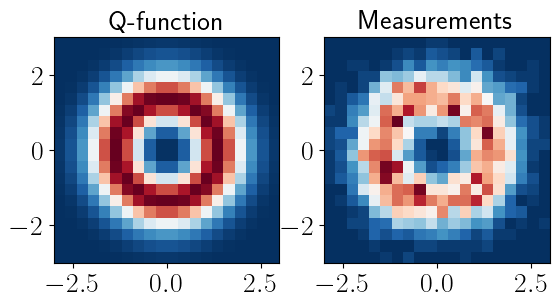

In [20]:
Nbins=20

xvec = np.linspace(-3.,3.,Nbins)
Q_comp = qfunc(initial_cavity, xvec, xvec, g=2) # ideal Q-function

real_meas = np.real(np.array(quadmeas))
imag_meas = np.imag(np.array(quadmeas))

hist, xedges, yedges = np.histogram2d(real_meas, imag_meas, Nbins,range=[[-3,3],[-3,3]],normed=True)

fig, ax = plt.subplots(1,2)
fig1 = ax[0].imshow(Q_comp,extent=[-3,3,-3,3], cmap=cm.RdBu_r)
ax[0].set_title('Q-function')
### TRANSPOSE
hist = hist.T

fig2=ax[1].imshow(hist, extent=[-3,3,-3,3], cmap=cm.RdBu_r)
ax[1].set_title('Measurements');
#fig.colorbar(fig2,fraction=0.046, pad=0.04);
#plt.savefig('/home/ingrid/presentations/CV_meetings/cat_workshop_20221025_qubitdyne/Q_fock2.png')

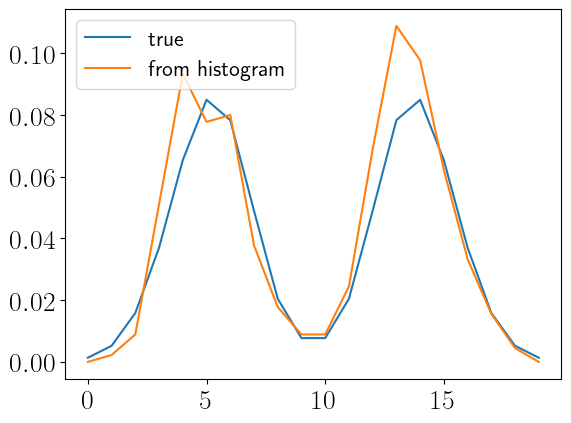

In [21]:
# compare slice through Q-func
k=8
plt.plot(Q_comp[:,k], label='true')
plt.plot(hist[:,k], label='from histogram')
plt.legend();

# Tomography

In [22]:
b=hist.flatten()

### Define Q-function measurement operators

In [23]:
def qfunc_ops(hilbert_size, beta):
    
    # need the larger Hilbert space to not get erroneous operators for large beta
    op = coherent_dm(50, beta)/np.pi
    op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        
    return op

### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [24]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

In [25]:
# Use midpoint of grid as phase space points
xvec2 = []
for idx, x in enumerate(xedges[:-1]):
    xvec2.append((x + xedges[idx+1])/2)

yvec2 = []
for idx, y in enumerate(yedges[:-1]):
    yvec2.append((y + yedges[idx+1])/2)
   

xvec = xvec2
yvec = yvec2
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

In [26]:
Pis = Parallel(n_jobs=30, verbose=5, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

[Parallel(n_jobs=30)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    4.5s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    8.7s
[Parallel(n_jobs=30)]: Done 400 out of 400 | elapsed:   13.6s finished
[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 7809 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    0.3s finished


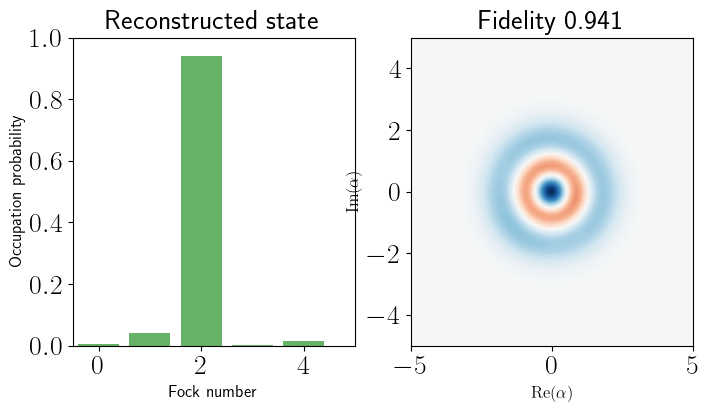

In [27]:
### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));
